In [2]:
import logging
import math

import numpy as np
from PIL import Image
from torchvision import datasets
from torchvision import transforms

import random

import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image

import torch
import argparse
import logging
import math
import os
import random
import shutil
import time
from collections import OrderedDict

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

from copy import deepcopy
import seaborn as sn

logger = logging.getLogger(__name__)

# randaugment.py

In [3]:
PARAMETER_MAX = 10


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [(AutoContrast, None, None),
            (Brightness, 0.9, 0.05),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Equalize, None, None),
            (Identity, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 0.9, 0.05),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (TranslateX, 0.3, 0),
            (TranslateY, 0.3, 0)]
    return augs


def my_augment_pool():
    # Test
    augs = [(AutoContrast, None, None),
            (Brightness, 1.8, 0.1),
            (Color, 1.8, 0.1),
            (Contrast, 1.8, 0.1),
            (Cutout, 0.2, 0),
            (Equalize, None, None),
            (Invert, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 1.8, 0.1),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (SolarizeAdd, 110, 0),
            (TranslateX, 0.45, 0),
            (TranslateY, 0.45, 0)]
    return augs


class RandAugmentPC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = my_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            prob = np.random.uniform(0.2, 0.8)
            if random.random() + prob >= 1:
                img = op(img, v=self.m, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img


class RandAugmentMC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img

# dataset.py

In [ ]:
print(df.iloc[0])
img = Image.open(df.image[0])
annot = df.class_id[0]

plt.imshow(img)
plt.title(annot)
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
logger = logging.getLogger(__name__)

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)
normal_mean = (0.5, 0.5, 0.5)
normal_std = (0.5, 0.5, 0.5)
img_mean = (0.485, 0.456, 0.406)
img_std = (0.229, 0.224, 0.225)


def get_oxfordIIIT(args, root):
    transform_labeled = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=img_mean, std=img_std)
    ])
    transform_val = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=img_mean, std=img_std)
    ])
    
    train_dataset = datasets.OxfordIIITPet(root, split='trainval', download=True)
    
    train_labeled_idxs, train_unlabeled_idxs = x_u_split(
        args, np.array(train_dataset._labels))

    train_labeled_dataset = OXFORDIIITSSL(
        root, train_labeled_idxs, split='trainval',
        transform=transform_labeled)

    train_unlabeled_dataset = OXFORDIIITSSL(
        root, train_unlabeled_idxs, split='trainval',
        transform=TransformFixMatch(mean=img_mean, std=img_std, resize=True))

    test_dataset = datasets.OxfordIIITPet(
        root, split='test', transform=transform_val, download=False)

    return train_labeled_dataset, train_unlabeled_dataset, test_dataset

def get_cifar10(args, root):
    transform_labeled = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=32,
                              padding=int(32*0.125),
                              padding_mode='reflect'),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
    ])
    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
    ])
    base_dataset = datasets.CIFAR10(root, train=True, download=True)

    train_labeled_idxs, train_unlabeled_idxs = x_u_split(
        args, base_dataset.targets)

    train_labeled_dataset = CIFAR10SSL(
        root, train_labeled_idxs, train=True,
        transform=transform_labeled)

    train_unlabeled_dataset = CIFAR10SSL(
        root, train_unlabeled_idxs, train=True,
        transform=TransformFixMatch(mean=cifar10_mean, std=cifar10_std, resize=False))

    test_dataset = datasets.CIFAR10(
        root, train=False, transform=transform_val, download=False)

    return train_labeled_dataset, train_unlabeled_dataset, test_dataset


def get_cifar100(args, root):

    transform_labeled = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=32,
                              padding=int(32*0.125),
                              padding_mode='reflect'),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar100_mean, std=cifar100_std)])

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar100_mean, std=cifar100_std)])

    base_dataset = datasets.CIFAR100(
        root, train=True, download=True)

    train_labeled_idxs, train_unlabeled_idxs = x_u_split(
        args, base_dataset.targets)

    train_labeled_dataset = CIFAR100SSL(
        root, train_labeled_idxs, train=True,
        transform=transform_labeled)

    train_unlabeled_dataset = CIFAR100SSL(
        root, train_unlabeled_idxs, train=True,
        transform=TransformFixMatch(mean=cifar100_mean, std=cifar100_std), resize=False)

    test_dataset = datasets.CIFAR100(
        root, train=False, transform=transform_val, download=False)

    return train_labeled_dataset, train_unlabeled_dataset, test_dataset


def x_u_split(args, labels):
    label_per_class = args.num_labeled // args.num_classes
    labels = np.array(labels)
    labeled_idx = []
    # unlabeled data: all data (https://github.com/kekmodel/FixMatch-pytorch/issues/10)
    unlabeled_idx = np.array(range(len(labels)))
    for i in range(args.num_classes):
        idx = np.where(labels == i)[0]
        idx = np.random.choice(idx, label_per_class, False)
        labeled_idx.extend(idx)
    labeled_idx = np.array(labeled_idx)
    assert len(labeled_idx) == args.num_labeled

    if args.expand_labels or args.num_labeled < args.batch_size:
        num_expand_x = math.ceil(
            args.batch_size * args.eval_step / args.num_labeled)
        labeled_idx = np.hstack([labeled_idx for _ in range(num_expand_x)])
    np.random.shuffle(labeled_idx)
    return labeled_idx, unlabeled_idx


class TransformFixMatch(object):
    def __init__(self, mean, std, resize):
        if resize == True:
            self.weak = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.Resize((224,224))])
            self.strong = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.Resize((224,224)),
                RandAugmentMC(n=2, m=10)])
        else:
            self.weak = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size=32,
                                      padding=int(32*0.125),
                                      padding_mode='reflect')])
            self.strong = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size=32,
                                      padding=int(32*0.125),
                                      padding_mode='reflect'),
                RandAugmentMC(n=2, m=10)])
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)

class OXFORDIIITSSL(datasets.OxfordIIITPet):
    def __init__(self, root, indexs, split='trainval',
                 transform=None, target_transform=None,
                 download=False):
        super().__init__(root, split=split,
                         transform=transform,
                         target_transform=target_transform,
                         download=download)
        if indexs is not None:
            self._images = np.array(self._images)[indexs]
            self._labels = np.array(self._labels)[indexs]

    def __getitem__(self, idx: int):
        image = Image.open(self._images[idx]).convert("RGB")
        target = self._labels[idx]

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target
    

class CIFAR10SSL(datasets.CIFAR10):
    def __init__(self, root, indexs, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super().__init__(root, train=train,
                         transform=transform,
                         target_transform=target_transform,
                         download=download)
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


class CIFAR100SSL(datasets.CIFAR100):
    def __init__(self, root, indexs, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super().__init__(root, train=train,
                         transform=transform,
                         target_transform=target_transform,
                         download=download)
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


DATASET_GETTERS = {'oxfordiiit':get_oxfordIIIT,
                   'cifar10': get_cifar10,
                   'cifar100': get_cifar100}

# utils.py

In [5]:
__all__ = ['get_mean_and_std', 'accuracy', 'AverageMeter']


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=False)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    logger.info('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:, i, :, :].mean()
            std[i] += inputs[:, i, :, :].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Import model

In [6]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "densenet201":
        """ Densenet 201
        """
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Initialize the model for this run

In [9]:
model_name = "resnet50"
num_classes = 37

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)

In [10]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
class ModelEMA(object):
    def __init__(self, args, model, decay):
        self.ema = deepcopy(model)
        self.ema.to(args.device)
        self.ema.eval()
        self.decay = decay
        self.ema_has_module = hasattr(self.ema, 'module')
        # Fix EMA. https://github.com/valencebond/FixMatch_pytorch thank you!
        self.param_keys = [k for k, _ in self.ema.named_parameters()]
        self.buffer_keys = [k for k, _ in self.ema.named_buffers()]
        for p in self.ema.parameters():
            p.requires_grad_(False)

    def update(self, model):
        needs_module = hasattr(model, 'module') and not self.ema_has_module
        with torch.no_grad():
            msd = model.state_dict()
            esd = self.ema.state_dict()
            for k in self.param_keys:
                if needs_module:
                    j = 'module.' + k
                else:
                    j = k
                model_v = msd[j].detach()
                ema_v = esd[k]
                esd[k].copy_(ema_v * self.decay + (1. - self.decay) * model_v)

            for k in self.buffer_keys:
                if needs_module:
                    j = 'module.' + k
                else:
                    j = k
                esd[k].copy_(msd[j])

# train.py

In [12]:
def get_confusion_matrix(test_dataset, device, model):
    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_dataset):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print("Confusion_matrix calculated.")
    return confusion_matrix.numpy()

In [ ]:
best_acc = 0


def save_checkpoint(state, is_best, checkpoint, filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint,
                                               'model_best.pth.tar'))


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)


def get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps,
                                    num_training_steps,
                                    num_cycles=7./16.,
                                    last_epoch=-1):
    def _lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        no_progress = float(current_step - num_warmup_steps) / \
            float(max(1, num_training_steps - num_warmup_steps))
        return max(0., math.cos(math.pi * num_cycles * no_progress))

    return LambdaLR(optimizer, _lr_lambda, last_epoch)


def interleave(x, size):
    s = list(x.shape)
    return x.reshape([-1, size] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])


def de_interleave(x, size):
    s = list(x.shape)
    return x.reshape([size, -1] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])


def main():
    parser = argparse.ArgumentParser(description='PyTorch FixMatch Training')
    parser.add_argument('--dataset', default='oxfordiiit', type=str,
                        choices=['oxfordiiit','cifar10', 'cifar100'],
                        help='dataset name')
    parser.add_argument('--num-labeled', type=int, default=370,
                        help='number of labeled data')
    parser.add_argument("--expand-labels", action="store_true", default=True,
                        help="expand labels to fit eval steps")
    parser.add_argument('--arch', default='resnet', type=str,
                        choices=['resnet'],
                        help='dataset name')
    parser.add_argument('--total-steps', default=2**8, type=int,
                        help='number of total steps to run')
    parser.add_argument('--eval-step', default=2**5, type=int,
                        help='number of eval steps to run')
    parser.add_argument('--start-epoch', default=0, type=int,
                        help='manual epoch number (useful on restarts)')
    parser.add_argument('--batch-size', default=2**5, type=int,
                        help='train batchsize')
    parser.add_argument('--lr', '--learning-rate', default=0.03, type=float,
                        help='initial learning rate')
    parser.add_argument('--warmup', default=0, type=float,
                        help='warmup epochs (unlabeled data based)')
    parser.add_argument('--wdecay', default=5e-4, type=float,
                        help='weight decay')
    parser.add_argument('--nesterov', action='store_true', default=True,
                        help='use nesterov momentum')
    parser.add_argument('--mu', default=7, type=int,
                        help='coefficient of unlabeled batch size')
    parser.add_argument('--lambda-u', default=1, type=float,
                        help='coefficient of unlabeled loss')
    parser.add_argument('--T', default=1, type=float,
                        help='pseudo label temperature')
    parser.add_argument('--threshold', default=0.95, type=float,
                        help='pseudo label threshold')
    parser.add_argument('--out', default='result',
                        help='directory to output the result')
    parser.add_argument('--resume', default='', type=str,
                        help='path to latest checkpoint (default: none)')
    parser.add_argument('--seed', default=None, type=int,
                        help="random seed")
    parser.add_argument('--no-progress', action='store_true',
                        help="don't use progress bar")
    parser.add_argument('--use-ema', action='store_true', default=True,
                        help='use EMA model')
    parser.add_argument('--ema-decay', default=0.999, type=float,
                        help='EMA decay rate')

    args = parser.parse_args("")
    print(args)
    global best_acc

    def create_model(args):
        if args.arch == 'resnet':
            return model_ft

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    args.world_size = 1
    args.device = device
    os.makedirs(args.out, exist_ok=True)
    args.writer = SummaryWriter(args.out)

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO)

    logger.warning(
        f"device: {args.device}, ")

    logger.info(dict(args._get_kwargs()))
    
    if args.dataset == 'cifar10':
        args.num_classes = 10

    elif args.dataset == 'cifar100':
        args.num_classes = 100
    
    elif args.dataset == 'oxfordiiit':
        args.num_classes = 37

    if args.seed is not None:
        set_seed(args)

    labeled_dataset, unlabeled_dataset, test_dataset = DATASET_GETTERS[args.dataset](
        
        args, './data')
  

    train_sampler = RandomSampler

    labeled_trainloader = DataLoader(
        labeled_dataset,
        sampler=train_sampler(labeled_dataset),
        batch_size=args.batch_size,
        drop_last=True)

    unlabeled_trainloader = DataLoader(
        unlabeled_dataset,
        sampler=train_sampler(unlabeled_dataset),
        batch_size=args.batch_size*args.mu,
        drop_last=True)

    test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=args.batch_size)
    return unlabeled_trainloader , unlabeled_dataset, labeled_dataset
#     model = create_model(args)
#     model.to(args.device)

#     no_decay = ['bias', 'bn']
#     grouped_parameters = [
#         {'params': [p for n, p in model.named_parameters() if not any(
#             nd in n for nd in no_decay)], 'weight_decay': args.wdecay},
#         {'params': [p for n, p in model.named_parameters() if any(
#             nd in n for nd in no_decay)], 'weight_decay': 0.0}
#     ]
#     optimizer = optim.SGD(grouped_parameters, lr=args.lr,
#                           momentum=0.9, nesterov=args.nesterov)

#     args.epochs = math.ceil(args.total_steps / args.eval_step)
#     scheduler = get_cosine_schedule_with_warmup(
#         optimizer, args.warmup, args.total_steps)
    
#     if args.use_ema:
#         ema_model = ModelEMA(args, model, args.ema_decay)
        
#     args.start_epoch = 0

#     if args.resume:
#         logger.info("==> Resuming from checkpoint..")
#         assert os.path.isfile(
#             args.resume), "Error: no checkpoint directory found!"
#         args.out = os.path.dirname(args.resume)
#         checkpoint = torch.load(args.resume)
#         best_acc = checkpoint['best_acc']
#         args.start_epoch = checkpoint['epoch']
#         model.load_state_dict(checkpoint['state_dict'])
#         if args.use_ema:
#             ema_model.ema.load_state_dict(checkpoint['ema_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer'])
#         scheduler.load_state_dict(checkpoint['scheduler'])


#     logger.info("***** Running training *****")
#     logger.info(f"  Task = {args.dataset}@{args.num_labeled}")
#     logger.info(f"  Num Epochs = {args.epochs}")
#     logger.info(f"  Batch size = {args.batch_size}")
#     logger.info(f"  Total optimization steps = {args.total_steps}")

#     model.zero_grad()
#     train_losses, train_accs, test_losses, test_accs, best_accs = train(args, labeled_trainloader, unlabeled_trainloader, test_loader,
#           model, optimizer, ema_model, scheduler)
#     confusion_matrix = get_confusion_matrix(test_loader, args.device, model)
    
#     return train_losses, train_accs, test_losses, test_accs, best_accs, confusion_matrix


# def train(args, labeled_trainloader, unlabeled_trainloader, test_loader,
#           model, optimizer, ema_model, scheduler):
#     global best_acc
#     test_losses = []
#     test_accs = []
#     best_accs = []
#     train_losses = []
#     train_accs = []
#     end = time.time()

#     if args.world_size > 1:
#         labeled_epoch = 0
#         unlabeled_epoch = 0
#         labeled_trainloader.sampler.set_epoch(labeled_epoch)
#         unlabeled_trainloader.sampler.set_epoch(unlabeled_epoch)

#     labeled_iter = iter(labeled_trainloader)
#     unlabeled_iter = iter(unlabeled_trainloader)

#     model.train()
#     for epoch in range(args.start_epoch, args.epochs):
#         batch_time = AverageMeter()
#         data_time = AverageMeter()
#         losses = AverageMeter()
#         losses_x = AverageMeter()
#         losses_u = AverageMeter()
#         mask_probs = AverageMeter()
#         train_step_accuracy = []
#         if not args.no_progress:
#             p_bar = tqdm(range(args.eval_step),
#                          disable=False)
#         for batch_idx in range(args.eval_step):
#             try:
#                 inputs_x, targets_x = labeled_iter.next()
#             except:
#                 if args.world_size > 1:
#                     labeled_epoch += 1
#                     labeled_trainloader.sampler.set_epoch(labeled_epoch)
#                 labeled_iter = iter(labeled_trainloader)
#                 inputs_x, targets_x = labeled_iter.next()

#             try:
#                 (inputs_u_w, inputs_u_s), _ = unlabeled_iter.next()
#             except:
#                 if args.world_size > 1:
#                     unlabeled_epoch += 1
#                     unlabeled_trainloader.sampler.set_epoch(unlabeled_epoch)
#                 unlabeled_iter = iter(unlabeled_trainloader)
#                 (inputs_u_w, inputs_u_s), _ = unlabeled_iter.next()

#             data_time.update(time.time() - end)
#             batch_size = inputs_x.shape[0]
#             inputs = interleave(
#                 torch.cat((inputs_x, inputs_u_w, inputs_u_s)), 2*args.mu+1).to(args.device)
#             targets_x = targets_x.to(args.device)
#             logits = model(inputs)
#             logits = de_interleave(logits, 2*args.mu+1)
#             logits_x = logits[:batch_size]
#             logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
#             del logits

#             Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')
#             train_acc = accuracy(logits_x,targets_x)
#             train_step_accuracy.append(train_acc[0].item())
            
#             pseudo_label = torch.softmax(logits_u_w.detach()/args.T, dim=-1)
#             max_probs, targets_u = torch.max(pseudo_label, dim=-1)
#             mask = max_probs.ge(args.threshold).float()

#             Lu = (F.cross_entropy(logits_u_s, targets_u,
#                                   reduction='none') * mask).mean()

#             loss = Lx + args.lambda_u * Lu

#             loss.backward()

#             losses.update(loss.item())
#             losses_x.update(Lx.item())
#             losses_u.update(Lu.item())
#             optimizer.step()
#             scheduler.step()
#             if args.use_ema:
#                 ema_model.update(model)
#             model.zero_grad()

#             batch_time.update(time.time() - end)
#             end = time.time()
#             mask_probs.update(mask.mean().item())
#             if not args.no_progress:
#                 p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. LR: {lr:.4f}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. Loss_x: {loss_x:.4f}. Loss_u: {loss_u:.4f}. Mask: {mask:.2f}. ".format(
#                     epoch=epoch + 1,
#                     epochs=args.epochs,
#                     batch=batch_idx + 1,
#                     iter=args.eval_step,
#                     lr=scheduler.get_last_lr()[0],
#                     data=data_time.avg,
#                     bt=batch_time.avg,
#                     loss=losses.avg,
#                     loss_x=losses_x.avg,
#                     loss_u=losses_u.avg,
#                     mask=mask_probs.avg))
#                 p_bar.update()

#         if not args.no_progress:
#             p_bar.close()

#         if args.use_ema:
#             test_model = ema_model.ema
#         else:
#             test_model = model

#         test_loss, test_acc = test(args, test_loader, test_model, epoch)

#         args.writer.add_scalar('train/1.train_loss', losses.avg, epoch)
#         args.writer.add_scalar('train/2.train_loss_x', losses_x.avg, epoch)
#         args.writer.add_scalar('train/3.train_loss_u', losses_u.avg, epoch)
#         args.writer.add_scalar('train/4.mask', mask_probs.avg, epoch)
#         args.writer.add_scalar('test/1.test_acc', test_acc, epoch)
#         args.writer.add_scalar('test/2.test_loss', test_loss, epoch)

#         is_best = test_acc > best_acc
#         best_acc = max(test_acc, best_acc)

#         model_to_save = model.module if hasattr(model, "module") else model
#         if args.use_ema:
#                 ema_to_save = ema_model.ema.module if hasattr(
#                     ema_model.ema, "module") else ema_model.ema
#         save_checkpoint({
#             'epoch': epoch + 1,
#             'state_dict': model_to_save.state_dict(),
#             'ema_state_dict': ema_to_save.state_dict() if args.use_ema else None,
#             'acc': test_acc,
#             'best_acc': best_acc,
#             'optimizer': optimizer.state_dict(),
#             'scheduler': scheduler.state_dict(),
#         }, is_best, args.out)
        
#         train_losses.append(losses.avg)
#         train_accs.append(np.average(train_step_accuracy))
#         test_losses.append(test_loss)
#         test_accs.append(test_acc)
#         best_accs.append(best_acc)
        
#         logger.info('Best top-1 acc: {:.2f}'.format(best_acc))
#         logger.info('Mean top-1 acc: {:.2f}\n'.format(
#             np.mean(test_accs[-20:])))

#     args.writer.close()
    
#     return train_losses, train_accs, test_losses, test_accs, best_accs


# def test(args, test_loader, model, epoch):
#     batch_time = AverageMeter()
#     data_time = AverageMeter()
#     losses = AverageMeter()
#     top1 = AverageMeter()
#     top5 = AverageMeter()
#     end = time.time()

#     if not args.no_progress:
#         test_loader = tqdm(test_loader,
#                            disable=False)

#     with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(test_loader):
#             data_time.update(time.time() - end)
#             model.eval()

#             inputs = inputs.to(args.device)
#             targets = targets.to(args.device)
#             outputs = model(inputs)
#             loss = F.cross_entropy(outputs, targets)

#             prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
#             losses.update(loss.item(), inputs.shape[0])
#             top1.update(prec1.item(), inputs.shape[0])
#             top5.update(prec5.item(), inputs.shape[0])
#             batch_time.update(time.time() - end)
#             end = time.time()
#             if not args.no_progress:
#                 test_loader.set_description("Test Iter: {batch:4}/{iter:4}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. top1: {top1:.2f}. top5: {top5:.2f}. ".format(
#                     batch=batch_idx + 1,
#                     iter=len(test_loader),
#                     data=data_time.avg,
#                     bt=batch_time.avg,
#                     loss=losses.avg,
#                     top1=top1.avg,
#                     top5=top5.avg,
#                 ))
#         if not args.no_progress:
#             test_loader.close()

#     logger.info("top-1 acc: {:.2f}".format(top1.avg))
#     logger.info("top-5 acc: {:.2f}".format(top5.avg))
#     return losses.avg, top1.avg
      

In [ ]:
def plot_all_graphs(train_losses, train_accs, test_losses, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="Green", marker='o')
    ax1.plot(range(len(test_losses)), test_losses, label="Test Loss", color="Red", marker='o')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax2.plot(range(len(train_accs)), train_accs, label="Training Accuracy", color="Green", marker='o')
    ax2.plot(range(len(test_accs)), test_accs, label="Test Accuracy", color="Red", marker='o')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    plt.savefig('loss-acc-plot.png')  
#     fig.suptitle("Network params: n_epochs=" + str(n_epochs) + ", n_batch=" + str(n_batch) + ", eta_min=" + str(eta_min) + ", lambda=" + str(Lambda))
    plt.show()
    plt.close(fig)

def plot_all_graphs(train_losses, train_accs, test_losses, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss", color="Green", marker='o')
    ax1.plot(range(1, len(test_losses)+1), test_losses, label="Test Loss", color="Red", marker='o')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax2.plot(range(1, len(train_accs)+1), train_accs, label="Training Accuracy", color="Green", marker='o')
    ax2.plot(range(1, len(test_accs)+1), test_accs, label="Test Accuracy", color="Red", marker='o')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
#     fig.suptitle("Network params: n_epochs=" + str(n_epochs) + ", n_batch=" + str(n_batch) + ", eta_min=" + str(eta_min) + ", lambda=" + str(Lambda))
    plt.savefig('loss-acc-plot.png')    
#     plt.show()
    plt.close(fig)

def plot_confusion_matrix(confusion_matrix, num_classes):
    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in range(num_classes)],
                  columns = [i for i in range(num_classes)])
    plt.figure(figsize = (16,8))
    sn.heatmap(df_cm, annot=True, fmt=".0f")

In [ ]:
def plot_confusion_matrix(confusion_matrix, num_classes):
    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in range(num_classes)],
                  columns = [i for i in range(num_classes)])
    plt.figure(figsize = (16,8))
    confusion_plot = sn.heatmap(df_cm, annot=True, fmt=".0f")
    fig = confusion_plot.get_figure()
    fig.savefig("confusion-matrix.png")

In [ ]:
unlab, unlabeled , labeled = main()

In [ ]:
unlabeled_iter = iter(unlab)

In [ ]:
 (inputs_u_w, inputs_u_s), t = unlabeled_iter.next()

In [ ]:
inputs_u_w[0][0][0]

In [ ]:
 inputs_u_s[0][0][0]

In [ ]:
lab[0][0][2]

In [ ]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

In [ ]:
def imagenet_denorm(x):
    """x: array-like with shape (..., H, W, C)"""
    return x * imagenet_std + imagenet_mean

In [ ]:
for _ in range(3):
    plt.imshow(imagenet_denorm(img.numpy().transpose(1,2,0)))
    plt.title("%d" % label)
    plt.xticks([]); plt.yticks([])
    plt.show()

In [ ]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

def denormalize(x, mean=IMG_MEAN, std=IMG_STD):
    # 3, H, W, B
    ten = x.clone().permute(1, 2, 3, 0)
    for t, m, s in zip(ten, mean, std):
        t.mul_(s).add_(m)
    # B, 3, H, W
    return torch.clamp(ten, 0, 1).permute(3, 0, 1, 2)

In [ ]:
img =inputs_u_w
img_d = denormalize(img)

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(inputs_u_w[0][0])
plt.show()

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(inputs_u_s[0][2],interpolation='nearest')
plt.show()

## def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

get_concat_h(im1, im1).save('data/dst/pillow_concat_h.jpg')
get_concat_v(im1, im1).save('data/dst/pillow_concat_v.jpg')


In [ ]:
from matplotlib import pyplot as plt
for i in range(0,5):
    plt.imshow(unlabeled[i][0][0][2], interpolation='nearest')
    plt.show()

In [ ]:
for i in range(5):
    image = unlabeled.__getitem__(i)
    final_image = image[0]
    plt.imshow(final_image.permute(1,2,0))
    plt.show()

In [13]:
def get_images():
    parser = argparse.ArgumentParser(description='PyTorch FixMatch Training')
    parser.add_argument('--dataset', default='oxfordiiit', type=str,
                        choices=['oxfordiiit','cifar10', 'cifar100'],
                        help='dataset name')
    parser.add_argument('--num-labeled', type=int, default=1850,
                        help='number of labeled data')
    parser.add_argument("--expand-labels", action="store_true", default=True,
                        help="expand labels to fit eval steps")
    parser.add_argument('--arch', default='resnet', type=str,
                        choices=['resnet'],
                        help='dataset name')
    parser.add_argument('--total-steps', default=2**8, type=int,
                        help='number of total steps to run')
    parser.add_argument('--eval-step', default=2**5, type=int,
                        help='number of eval steps to run')
    parser.add_argument('--start-epoch', default=0, type=int,
                        help='manual epoch number (useful on restarts)')
    parser.add_argument('--batch-size', default=2**5, type=int,
                        help='train batchsize')
    parser.add_argument('--lr', '--learning-rate', default=0.03, type=float,
                        help='initial learning rate')
    parser.add_argument('--warmup', default=0, type=float,
                        help='warmup epochs (unlabeled data based)')
    parser.add_argument('--wdecay', default=5e-3, type=float,
                        help='weight decay')
    parser.add_argument('--nesterov', action='store_true', default=True,
                        help='use nesterov momentum')
    parser.add_argument('--mu', default=7, type=int,
                        help='coefficient of unlabeled batch size')
    parser.add_argument('--lambda-u', default=1, type=float,
                        help='coefficient of unlabeled loss')
    parser.add_argument('--T', default=1, type=float,
                        help='pseudo label temperature')
    parser.add_argument('--threshold', default=0.95, type=float,
                        help='pseudo label threshold')
    parser.add_argument('--out', default='result',
                        help='directory to output the result')
    parser.add_argument('--resume', default='', type=str,
                        help='path to latest checkpoint (default: none)')
    parser.add_argument('--seed', default=None, type=int,
                        help="random seed")
    parser.add_argument('--no-progress', action='store_true',
                        help="don't use progress bar")
    parser.add_argument('--use-ema', action='store_true', default=True,
                        help='use EMA model')
    parser.add_argument('--ema-decay', default=0.999, type=float,
                        help='EMA decay rate')

    args = parser.parse_args("")
    print(args)
    global best_acc

    def create_model(args):
        if args.arch == 'resnet':
            return model_ft

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    args.world_size = 1
    args.device = device
    os.makedirs(args.out, exist_ok=True)
    args.writer = SummaryWriter(args.out)

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO)

    logger.warning(
        f"device: {args.device}, ")

    logger.info(dict(args._get_kwargs()))
    
    if args.dataset == 'cifar10':
        args.num_classes = 10

    elif args.dataset == 'cifar100':
        args.num_classes = 100
    
    elif args.dataset == 'oxfordiiit':
        args.num_classes = 37

    if args.seed is not None:
        set_seed(args)

    labeled_dataset, unlabeled_dataset, test_dataset = DATASET_GETTERS[args.dataset](
        args, './data')
    
    return labeled_dataset, unlabeled_dataset

In [14]:
labeled_dataset, unlabeled_dataset = get_images()

Namespace(T=1, arch='resnet', batch_size=32, dataset='oxfordiiit', ema_decay=0.999, eval_step=32, expand_labels=True, lambda_u=1, lr=0.03, mu=7, nesterov=True, no_progress=False, num_labeled=1850, out='result', resume='', seed=None, start_epoch=0, threshold=0.95, total_steps=256, use_ema=True, warmup=0, wdecay=0.005)


In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(image_datas[0])
axarr[0,1].imshow(image_datas[1])
axarr[1,0].imshow(image_datas[2])
axarr[1,1].imshow(image_datas[3]

In [57]:
final = []
def print_images(unlabeled_dataset):
    for i in range(5):
        for j in range(2):
            image = unlabeled_dataset.__getitem__(i)
            final_image = image[0][j]
            final.append(final_image)
            plt.imshow(final_image.permute(1, 2, 0))
            plt.show()
    return final

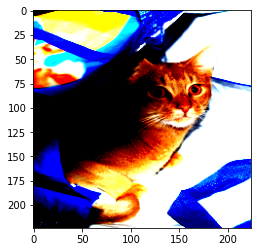

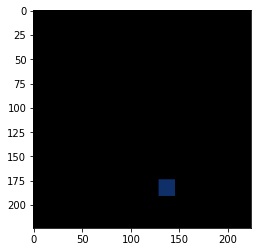

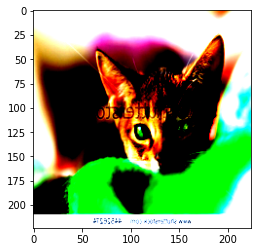

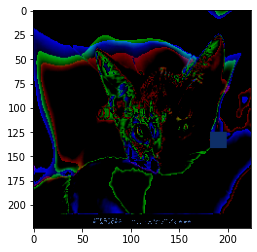

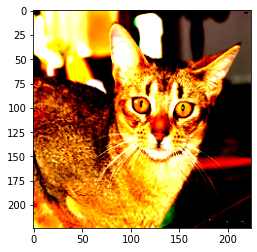

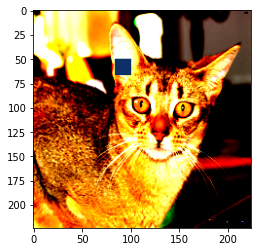

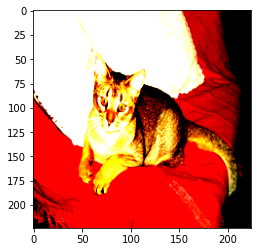

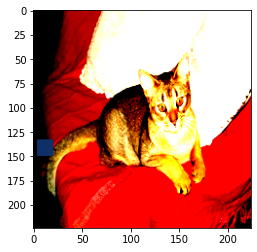

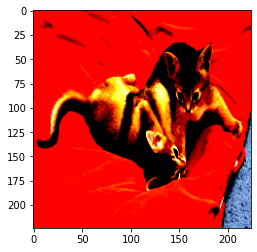

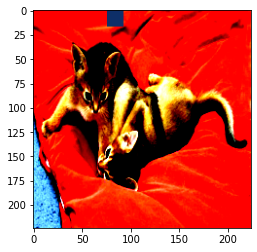

In [67]:
list_f = print_images(unlabeled_dataset)

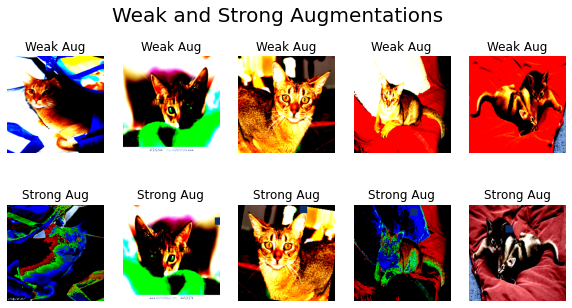

In [37]:

f, axarr = plt.subplots(2,5,figsize=(20,20))
f.set_figheight(5)
f.set_figwidth(10)
f.suptitle('Weak and Strong Augmentations', fontsize=20)
axarr[0,0].imshow(list_f[0].permute(1, 2, 0))
axarr[0,0].axis('off')
axarr[0,0].set_title("Weak Aug")
axarr[0,1].imshow(list_f[2].permute(1, 2, 0))
axarr[0,1].axis('off')
axarr[0,1].set_title("Weak Aug")
axarr[0,2].imshow(list_f[4].permute(1, 2, 0))
axarr[0,2].axis('off')
axarr[0,2].set_title("Weak Aug")
axarr[0,3].imshow(list_f[6].permute(1, 2, 0))
axarr[0,3].axis('off')
axarr[0,3].set_title("Weak Aug")
axarr[0,4].imshow(list_f[8].permute(1, 2, 0))
axarr[0,4].axis('off')
axarr[0,4].set_title("Weak Aug")
axarr[1,0].imshow(list_f[1].permute(1, 2, 0))
axarr[1,0].axis('off')
axarr[1,0].set_title("Strong Aug")
axarr[1,1].imshow(list_f[3].permute(1, 2, 0))
axarr[1,1].axis('off')
axarr[1,1].set_title("Strong Aug")
axarr[1,2].imshow(list_f[5].permute(1, 2, 0))
axarr[1,2].axis('off')
axarr[1,2].set_title("Strong Aug")
axarr[1,3].imshow(list_f[7].permute(1, 2, 0))
axarr[1,3].axis('off')
axarr[1,3].set_title("Strong Aug")
axarr[1,4].imshow(list_f[9].permute(1, 2, 0))
axarr[1,4].axis('off')
axarr[1,4].set_title("Strong Aug")
f.savefig('Weak&Strong.png')



In [ ]:
axarr[0.set_title("Title for second plot")

TypeError: cannot unpack non-iterable int object

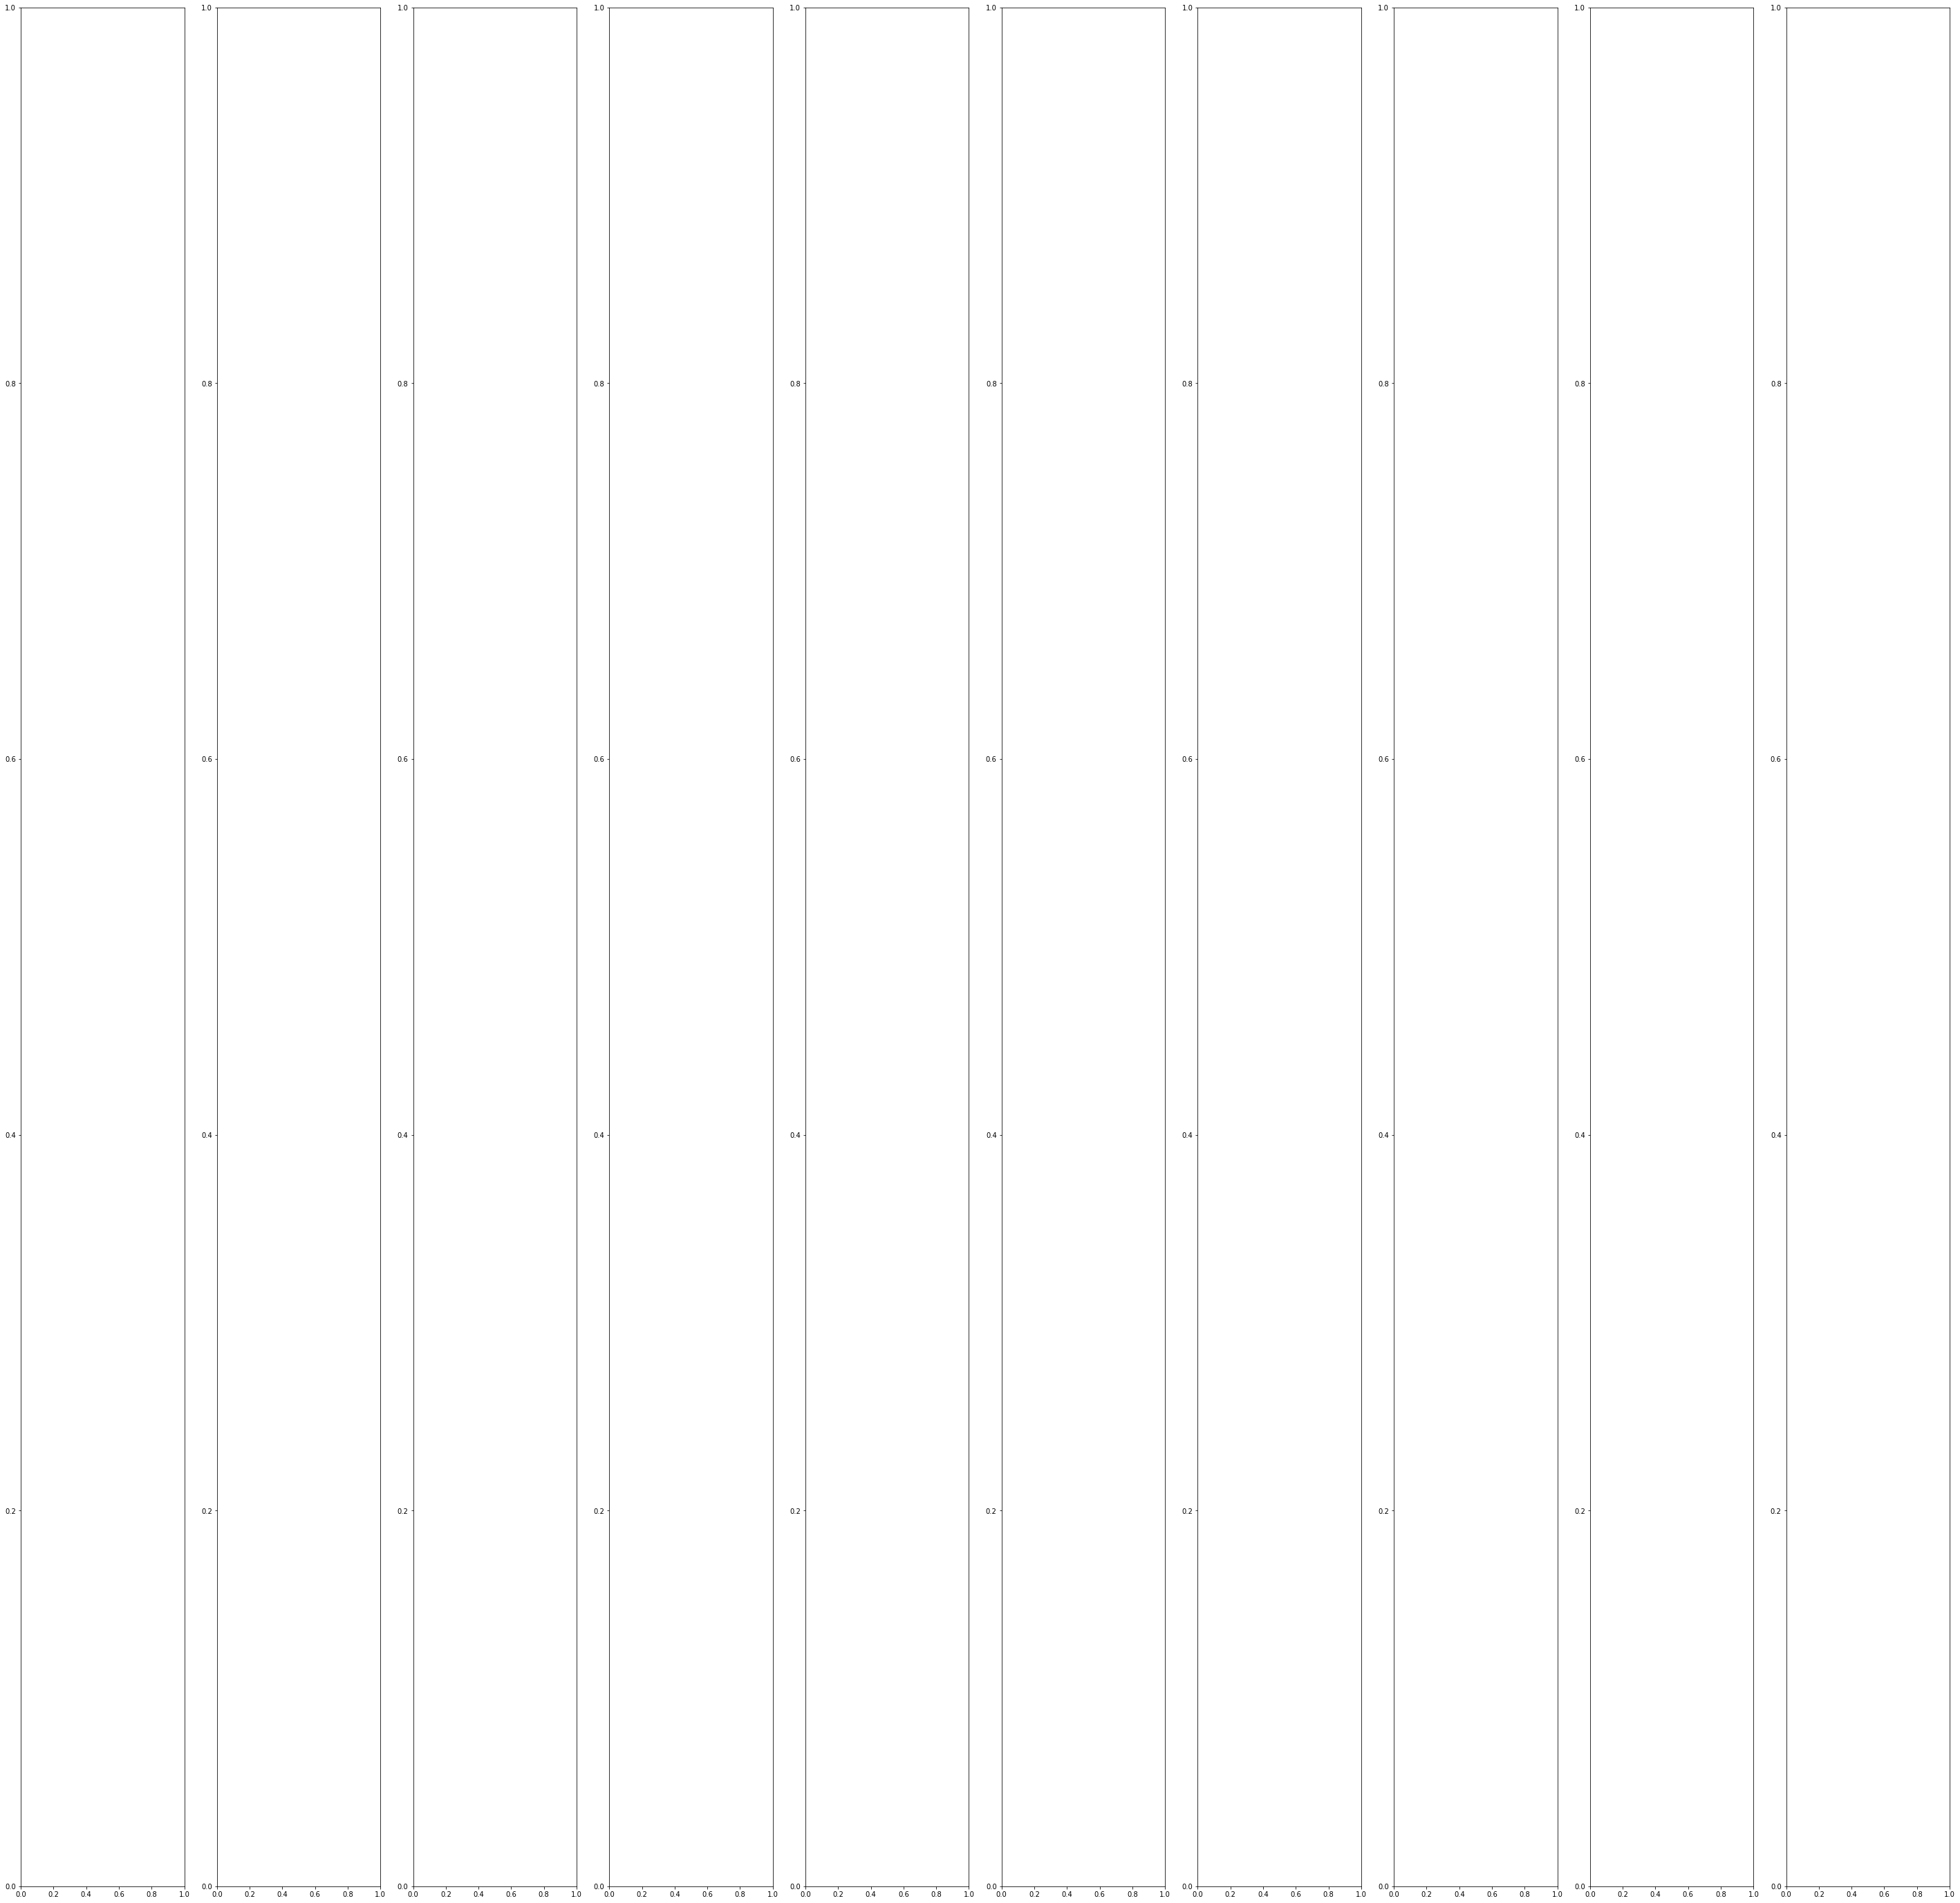

In [24]:
f, axarr = plt.subplots(1,10)
f.set_figheight(50)
f.set_figwidth(50)

for i ,j in range(len(list_f)):
    axarr[i].imshow(list_f[i].permute(1, 2, 0))
    axarr[i].axis('off')
    if i%2==0:
        axarr[i].set_title("Weak Aug")
    else:
        axarr[i].set_title("Strong Aug")
        
# axarr[1].imshow(list_f[1].permute(1, 2, 0))
# axarr[1].axis('off')
# axarr[2].imshow(list_f[2].permute(1, 2, 0))
# axarr[2].axis('off')
# axarr[3].imshow(list_f[3].permute(1, 2, 0))
# axarr[3].axis('off')
# axarr[4].imshow(list_f[4].permute(1, 2, 0))
# axarr[4].axis('off')
# axarr[5].imshow(list_f[5].permute(1, 2, 0))
# axarr[5].axis('off')
# axarr[6].imshow(list_f[6].permute(1, 2, 0))
# axarr[6].axis('off')
# axarr[7].imshow(list_f[7].permute(1, 2, 0))
# axarr[7].axis('off')
# axarr[8].imshow(list_f[8].permute(1, 2, 0))
# axarr[8].axis('off')
# axarr[9].imshow(list_f[9].permute(1, 2, 0))
# axarr[9].axis('off')
f.savefig('Weak&Strong.png')


In [ ]:
f, axarr = plt.subplots(1,10)
f.set_figheight(50)
f.set_figwidth(50)

axarr[0].imshow(list_f[0].permute(1, 2, 0))
axarr[0].axis('off')
axarr[0].set_title("Weak Aug")
axarr[1].imshow(list_f[2].permute(1, 2, 0))
axarr[1].axis('off')
axarr[1].set_title("Weak Aug")
axarr[2].imshow(list_f[4].permute(1, 2, 0))
axarr[2].axis('off')
axarr[2].set_title("Weak Aug")
axarr[3].imshow(list_f[6].permute(1, 2, 0))
axarr[3].axis('off')
axarr[3].set_title("Weak Aug")
axarr[4].imshow(list_f[8].permute(1, 2, 0))
axarr[4].axis('off')
axarr[5].imshow(list_f[1].permute(1, 2, 0))
axarr[5].axis('off')
axarr[6].imshow(list_f[3].permute(1, 2, 0))
axarr[6].axis('off')
axarr[7].imshow(list_f[5].permute(1, 2, 0))
axarr[7].axis('off')
axarr[8].imshow(list_f[7].permute(1, 2, 0))
axarr[8].axis('off')
axarr[9].imshow(list_f[9].permute(1, 2, 0))
axarr[9].axis('off')
f.savefig('Weak&Strong.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg' # 'svg', 'retina'
plt.style.use('seaborn-white')

# Make dummy data for the image

# Show subplots | shape: (1,3) 
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12,4))
for i, ax in enumerate(axs.flatten()):
#     plt.sca(ax)
    plt.imshow(list_f[i].permute(1, 2, 0))
    #plt.colorbar()
    #plt.title('Image: {}'.format(i+1))

#plt.tight_layout()
plt.suptitle('Overall Title')
plt.show()

In [ ]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure(figsize =(5.0,5))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = list_of_files[i]
        imshow(image.permute(1, 2, 0),interpolation='nearest',aspect='equal')
        axis('off')

In [ ]:
showImagesHorizontally(list_f)

In [ ]:
import matplotlib.pyplot as plt 
f,ax = plt.subplots(2,5)
for i in range(len(list_f)):
    ax[i].imshow(list_f[i].permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, list_f):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [ ]:
from matplotlib import pyplot as plt
for i in range(0,5):
    plt.imshow(unlabeled[i][0][1][2], interpolation='nearest')
    plt.show()

In [ ]:

from matplotlib import pyplot as plt
plt.imshow(labeled[0][0][2], interpolation='nearest')
plt.show()

In [ ]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [ ]:
unlab[0][0]

In [ ]:
plot_all_graphs(train_losses, train_accs, test_losses, test_accs)

In [ ]:
plot_confusion_matrix(confusion_matrix, num_classes)

In [ ]:
test_accs

In [ ]:
train_accs

In [ ]:
best_acc = 0


def save_checkpoint(state, is_best, checkpoint, filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint,
                                               'model_best.pth.tar'))


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)


def get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps,
                                    num_training_steps,
                                    num_cycles=7./16.,
                                    last_epoch=-1):
    def _lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        no_progress = float(current_step - num_warmup_steps) / \
            float(max(1, num_training_steps - num_warmup_steps))
        return max(0., math.cos(math.pi * num_cycles * no_progress))

    return LambdaLR(optimizer, _lr_lambda, last_epoch)


def interleave(x, size):
    s = list(x.shape)
    return x.reshape([-1, size] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])


def de_interleave(x, size):
    s = list(x.shape)
    return x.reshape([size, -1] + s[1:]).transpose(0, 1).reshape([-1] + s[1:])


def main():
    parser = argparse.ArgumentParser(description='PyTorch FixMatch Training')
    parser.add_argument('--dataset', default='oxfordiiit', type=str,
                        choices=['oxfordiiit','cifar10', 'cifar100'],
                        help='dataset name')
    parser.add_argument('--num-labeled', type=int, default=2775,
                        help='number of labeled data')
    parser.add_argument("--expand-labels", action="store_true", default=True,
                        help="expand labels to fit eval steps")
    parser.add_argument('--arch', default='resnet', type=str,
                        choices=['resnet'],
                        help='dataset name')
    parser.add_argument('--total-steps', default=2**8, type=int,
                        help='number of total steps to run')
    parser.add_argument('--eval-step', default=2**5, type=int,
                        help='number of eval steps to run')
    parser.add_argument('--start-epoch', default=0, type=int,
                        help='manual epoch number (useful on restarts)')
    parser.add_argument('--batch-size', default=2**5, type=int,
                        help='train batchsize')
    parser.add_argument('--lr', '--learning-rate', default=0.03, type=float,
                        help='initial learning rate')
    parser.add_argument('--warmup', default=0, type=float,
                        help='warmup epochs (unlabeled data based)')
    parser.add_argument('--wdecay', default=5e-4, type=float,
                        help='weight decay')
    parser.add_argument('--nesterov', action='store_true', default=True,
                        help='use nesterov momentum')
    parser.add_argument('--mu', default=7, type=int,
                        help='coefficient of unlabeled batch size')
    parser.add_argument('--lambda-u', default=1, type=float,
                        help='coefficient of unlabeled loss')
    parser.add_argument('--T', default=1, type=float,
                        help='pseudo label temperature')
    parser.add_argument('--threshold', default=0.95, type=float,
                        help='pseudo label threshold')
    parser.add_argument('--out', default='result',
                        help='directory to output the result')
    parser.add_argument('--resume', default='', type=str,
                        help='path to latest checkpoint (default: none)')
    parser.add_argument('--seed', default=None, type=int,
                        help="random seed")
    parser.add_argument('--no-progress', action='store_true',
                        help="don't use progress bar")
    parser.add_argument('--use-ema', action='store_true', default=True,
                        help='use EMA model')
    parser.add_argument('--ema-decay', default=0.999, type=float,
                        help='EMA decay rate')

    args = parser.parse_args("")
    print(args)
    global best_acc

    def create_model(args):
        if args.arch == 'resnet':
            return model_ft

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    args.world_size = 1
    args.device = device
    os.makedirs(args.out, exist_ok=True)
    args.writer = SummaryWriter(args.out)

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO)

    logger.warning(
        f"device: {args.device}, ")

    logger.info(dict(args._get_kwargs()))
    
    if args.dataset == 'cifar10':
        args.num_classes = 10

    elif args.dataset == 'cifar100':
        args.num_classes = 100
    
    elif args.dataset == 'oxfordiiit':
        args.num_classes = 37

    if args.seed is not None:
        set_seed(args)

    labeled_dataset, unlabeled_dataset, test_dataset = DATASET_GETTERS[args.dataset](
        args, './data')


    train_sampler = RandomSampler

    labeled_trainloader = DataLoader(
        labeled_dataset,
        sampler=train_sampler(labeled_dataset),
        batch_size=args.batch_size,
        drop_last=True)

    unlabeled_trainloader = DataLoader(
        unlabeled_dataset,
        sampler=train_sampler(unlabeled_dataset),
        batch_size=args.batch_size*args.mu,
        drop_last=True)

    test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=args.batch_size)

    model = create_model(args)
    model.to(args.device)

    no_decay = ['bias', 'bn']
    grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(
            nd in n for nd in no_decay)], 'weight_decay': args.wdecay},
        {'params': [p for n, p in model.named_parameters() if any(
            nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = optim.SGD(grouped_parameters, lr=args.lr,
                          momentum=0.9, nesterov=args.nesterov)

    args.epochs = math.ceil(args.total_steps / args.eval_step)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, args.warmup, args.total_steps)
    
    if args.use_ema:
        ema_model = ModelEMA(args, model, args.ema_decay)
        
    args.start_epoch = 0

    if args.resume:
        logger.info("==> Resuming from checkpoint..")
        assert os.path.isfile(
            args.resume), "Error: no checkpoint directory found!"
        args.out = os.path.dirname(args.resume)
        checkpoint = torch.load(args.resume)
        best_acc = checkpoint['best_acc']
        args.start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        if args.use_ema:
            ema_model.ema.load_state_dict(checkpoint['ema_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])


    logger.info("***** Running training *****")
    logger.info(f"  Task = {args.dataset}@{args.num_labeled}")
    logger.info(f"  Num Epochs = {args.epochs}")
    logger.info(f"  Batch size = {args.batch_size}")
    logger.info(f"  Total optimization steps = {args.total_steps}")

    model.zero_grad()
    train_losses, train_accs, test_losses, test_accs, best_accs = train(args, labeled_trainloader, unlabeled_trainloader, test_loader,
          model, optimizer, ema_model, scheduler)
    confusion_matrix = get_confusion_matrix(test_loader, args.device, model)
    
    return train_losses, train_accs, test_losses, test_accs, best_accs, confusion_matrix


def train(args, labeled_trainloader, unlabeled_trainloader, test_loader,
          model, optimizer, ema_model, scheduler):
    global best_acc
    test_losses = []
    test_accs = []
    best_accs = []
    train_losses = []
    train_accs = []
    end = time.time()

    if args.world_size > 1:
        labeled_epoch = 0
        unlabeled_epoch = 0
        labeled_trainloader.sampler.set_epoch(labeled_epoch)
        unlabeled_trainloader.sampler.set_epoch(unlabeled_epoch)

    labeled_iter = iter(labeled_trainloader)
    unlabeled_iter = iter(unlabeled_trainloader)

    model.train()
    for epoch in range(args.start_epoch, args.epochs):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        mask_probs = AverageMeter()
        train_step_accuracy = []
        if not args.no_progress:
            p_bar = tqdm(range(args.eval_step),
                         disable=False)
        for batch_idx in range(args.eval_step):
            try:
                inputs_x, targets_x = labeled_iter.next()
            except:
                if args.world_size > 1:
                    labeled_epoch += 1
                    labeled_trainloader.sampler.set_epoch(labeled_epoch)
                labeled_iter = iter(labeled_trainloader)
                inputs_x, targets_x = labeled_iter.next()

            try:
                (inputs_u_w, inputs_u_s), _ = unlabeled_iter.next()
            except:
                if args.world_size > 1:
                    unlabeled_epoch += 1
                    unlabeled_trainloader.sampler.set_epoch(unlabeled_epoch)
                unlabeled_iter = iter(unlabeled_trainloader)
                (inputs_u_w, inputs_u_s), _ = unlabeled_iter.next()

            data_time.update(time.time() - end)
            batch_size = inputs_x.shape[0]
            inputs = interleave(
                torch.cat((inputs_x, inputs_u_w, inputs_u_s)), 2*args.mu+1).to(args.device)
            targets_x = targets_x.to(args.device)
            logits = model(inputs)
            logits = de_interleave(logits, 2*args.mu+1)
            logits_x = logits[:batch_size]
            logits_u_w, logits_u_s = logits[batch_size:].chunk(2)
            del logits

            Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')
            train_acc = accuracy(logits_x,targets_x)
            train_step_accuracy.append(train_acc[0].item())
            
            pseudo_label = torch.softmax(logits_u_w.detach()/args.T, dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = max_probs.ge(args.threshold).float()

            Lu = (F.cross_entropy(logits_u_s, targets_u,
                                  reduction='none') * mask).mean()

            loss = Lx + args.lambda_u * Lu

            loss.backward()

            losses.update(loss.item())
            losses_x.update(Lx.item())
            losses_u.update(Lu.item())
            optimizer.step()
            scheduler.step()
            if args.use_ema:
                ema_model.update(model)
            model.zero_grad()

            batch_time.update(time.time() - end)
            end = time.time()
            mask_probs.update(mask.mean().item())
            if not args.no_progress:
                p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. LR: {lr:.4f}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. Loss_x: {loss_x:.4f}. Loss_u: {loss_u:.4f}. Mask: {mask:.2f}. ".format(
                    epoch=epoch + 1,
                    epochs=args.epochs,
                    batch=batch_idx + 1,
                    iter=args.eval_step,
                    lr=scheduler.get_last_lr()[0],
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    loss_x=losses_x.avg,
                    loss_u=losses_u.avg,
                    mask=mask_probs.avg))
                p_bar.update()

        if not args.no_progress:
            p_bar.close()

        if args.use_ema:
            test_model = ema_model.ema
        else:
            test_model = model

        test_loss, test_acc = test(args, test_loader, test_model, epoch)

        args.writer.add_scalar('train/1.train_loss', losses.avg, epoch)
        args.writer.add_scalar('train/2.train_loss_x', losses_x.avg, epoch)
        args.writer.add_scalar('train/3.train_loss_u', losses_u.avg, epoch)
        args.writer.add_scalar('train/4.mask', mask_probs.avg, epoch)
        args.writer.add_scalar('test/1.test_acc', test_acc, epoch)
        args.writer.add_scalar('test/2.test_loss', test_loss, epoch)

        is_best = test_acc > best_acc
        best_acc = max(test_acc, best_acc)

        model_to_save = model.module if hasattr(model, "module") else model
        if args.use_ema:
                ema_to_save = ema_model.ema.module if hasattr(
                    ema_model.ema, "module") else ema_model.ema
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model_to_save.state_dict(),
            'ema_state_dict': ema_to_save.state_dict() if args.use_ema else None,
            'acc': test_acc,
            'best_acc': best_acc,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
        }, is_best, args.out)
        
        train_losses.append(losses.avg)
        train_accs.append(np.average(train_step_accuracy))
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        best_accs.append(best_acc)
        
        logger.info('Best top-1 acc: {:.2f}'.format(best_acc))
        logger.info('Mean top-1 acc: {:.2f}\n'.format(
            np.mean(test_accs[-20:])))

    args.writer.close()
    
    return train_losses, train_accs, test_losses, test_accs, best_accs


def test(args, test_loader, model, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()

    if not args.no_progress:
        test_loader = tqdm(test_loader,
                           disable=False)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            data_time.update(time.time() - end)
            model.eval()

            inputs = inputs.to(args.device)
            targets = targets.to(args.device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)

            prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
            losses.update(loss.item(), inputs.shape[0])
            top1.update(prec1.item(), inputs.shape[0])
            top5.update(prec5.item(), inputs.shape[0])
            batch_time.update(time.time() - end)
            end = time.time()
            if not args.no_progress:
                test_loader.set_description("Test Iter: {batch:4}/{iter:4}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}. top1: {top1:.2f}. top5: {top5:.2f}. ".format(
                    batch=batch_idx + 1,
                    iter=len(test_loader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                ))
        if not args.no_progress:
            test_loader.close()

    logger.info("top-1 acc: {:.2f}".format(top1.avg))
    logger.info("top-5 acc: {:.2f}".format(top5.avg))
    return losses.avg, top1.avg

In [ ]:
train_losses, train_accs, test_losses, test_accs, best_accs, confusion_matrix = main()

In [ ]:
test_accs

In [ ]:
train_accs